In [1]:
!pip install scikit-fuzzy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 12.7 MB/s eta 0:00:00


In [ ]:
# تقدير خطورة الحريق في الغابات
# ظام خبير ضبابي يقدّر مستوى خطورة اندلاع حريق في الغابة بناءً على ثلاث مدخلات:

# درجة الحرارة (Temperature) — °C

# الرطوبة (Humidity) — %

# سرعة الرياح (Wind Speed) — كم/س

# والناتج هو: مستوى خطورة الحريق (Fire Risk) وهو متغير بثلاث قيم: منخفض، متوسط، عالي.

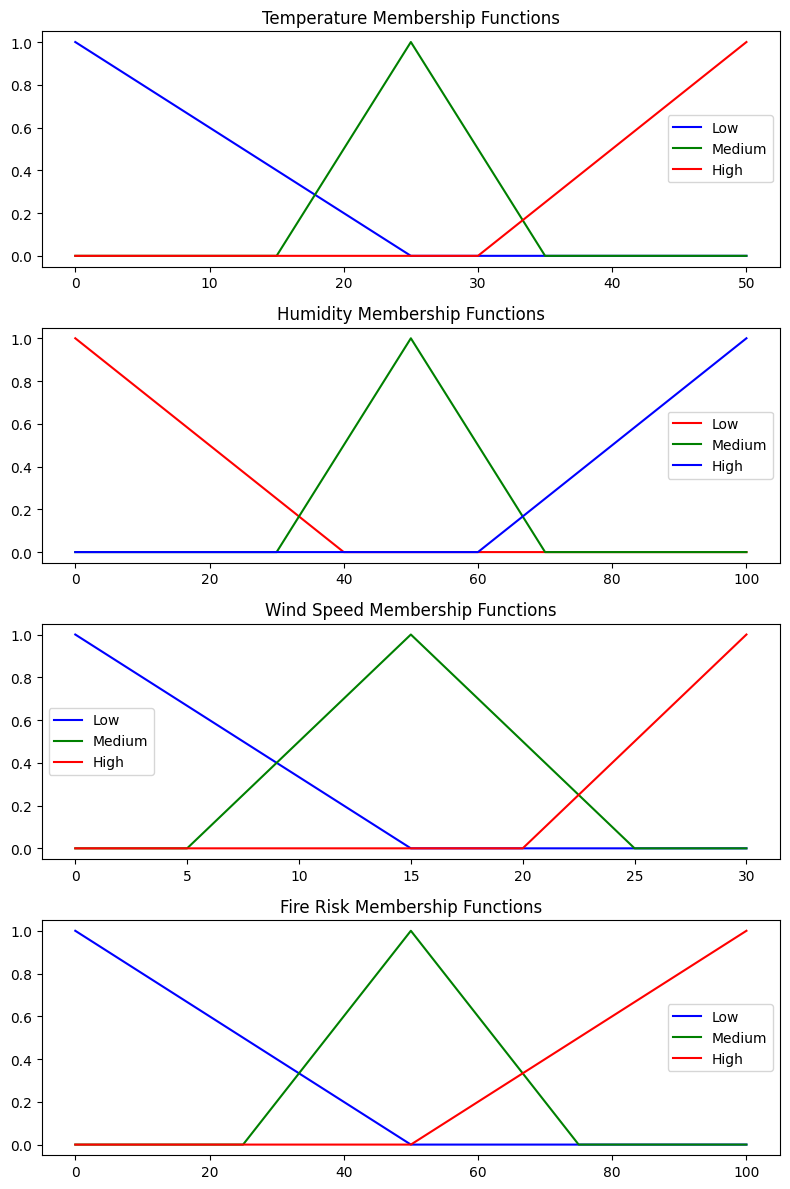

نظام تقدير خطورة الحريق في الغابات



In [ ]:
import numpy as np
import skfuzzy as fuzz
import skfuzzy.control as ctrl
import matplotlib.pyplot as plt

# 1. فضاءات القيم
temp = np.arange(0, 51, 1)
humidity = np.arange(0, 101, 1)
wind = np.arange(0, 31, 1)
risk = np.arange(0, 101, 1)

# 2. دوال العضوية لكل متغير

temp_low = fuzz.trimf(temp, [0, 0, 25])
temp_medium = fuzz.trimf(temp, [15, 25, 35])
temp_high = fuzz.trimf(temp, [30, 50, 50])

humidity_high = fuzz.trimf(humidity, [60, 100, 100])
humidity_medium = fuzz.trimf(humidity, [30, 50, 70])
humidity_low = fuzz.trimf(humidity, [0, 0, 40])

wind_low = fuzz.trimf(wind, [0, 0, 15])
wind_medium = fuzz.trimf(wind, [5, 15, 25])
wind_high = fuzz.trimf(wind, [20, 30, 30])

risk_low = fuzz.trimf(risk, [0, 0, 50])
risk_medium = fuzz.trimf(risk, [25, 50, 75])
risk_high = fuzz.trimf(risk, [50, 100, 100])

# 3. تعريف المتغيرات في النظام الضبابي

temperature = ctrl.Antecedent(temp, 'temperature')
humidity_var = ctrl.Antecedent(humidity, 'humidity')
wind_speed = ctrl.Antecedent(wind, 'wind_speed')
fire_risk = ctrl.Consequent(risk, 'fire_risk')

# 4. تعيين دوال العضوية

temperature['low'] = temp_low
temperature['medium'] = temp_medium
temperature['high'] = temp_high

humidity_var['low'] = humidity_low
humidity_var['medium'] = humidity_medium
humidity_var['high'] = humidity_high

wind_speed['low'] = wind_low
wind_speed['medium'] = wind_medium
wind_speed['high'] = wind_high

fire_risk['low'] = risk_low
fire_risk['medium'] = risk_medium
fire_risk['high'] = risk_high

# 5. تعيين طريقة التحديد الصريح

fire_risk.defuzzify_method = 'bisector'

# 6. كتابة قاعدة القواعد الموسعة

rule1 = ctrl.Rule(temperature['high'] & humidity_var['low'] & wind_speed['high'], fire_risk['high'])
rule2 = ctrl.Rule(temperature['medium'] & humidity_var['medium'] & wind_speed['medium'], fire_risk['medium'])
rule3 = ctrl.Rule(temperature['low'] & humidity_var['high'] & wind_speed['low'], fire_risk['low'])
rule4 = ctrl.Rule(temperature['high'] & humidity_var['medium'] & wind_speed['low'], fire_risk['medium'])
rule5 = ctrl.Rule(temperature['medium'] & humidity_var['low'] & wind_speed['high'], fire_risk['high'])
rule6 = ctrl.Rule(temperature['high'] & humidity_var['high'] & wind_speed['medium'], fire_risk['medium'])
rule7 = ctrl.Rule(temperature['medium'] & humidity_var['high'] & wind_speed['high'], fire_risk['medium'])
rule8 = ctrl.Rule(temperature['low'] & humidity_var['medium'] & wind_speed['high'], fire_risk['medium'])
rule9 = ctrl.Rule(temperature['low'] & humidity_var['low'] & wind_speed['medium'], fire_risk['medium'])
rule10 = ctrl.Rule(temperature['medium'] & humidity_var['medium'] & wind_speed['low'], fire_risk['medium'])

# 7. إعداد النظام والمحاكاة

fire_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5,
                                rule6, rule7, rule8, rule9, rule10])
fire_sim = ctrl.ControlSystemSimulation(fire_ctrl)

# 8. دالة التحقق من صحة المدخلات

def validate_inputs(temp_input, humidity_input, wind_input):
    errors = []
    if not (0 <= temp_input <= 50):
        errors.append("درجة الحرارة يجب أن تكون بين 0 و 50 °C.")
    if not (0 <= humidity_input <= 100):
        errors.append("الرطوبة يجب أن تكون بين 0 و 100%.")
    if not (0 <= wind_input <= 30):
        errors.append("سرعة الرياح يجب أن تكون بين 0 و 30 كم/س.")
    return errors

# 9. الواجهة التفاعلية

def fuzzy_fire_risk_system():
    print("نظام تقدير خطورة الحريق في الغابات\n")
    try:
        temp_input = float(input("أدخل درجة الحرارة (0-50 °C): "))
        humidity_input = float(input("أدخل الرطوبة (0-100%): "))
        wind_input = float(input("أدخل سرعة الرياح (0-30 كم/س): "))
    except ValueError:
        print("خطأ: الرجاء إدخال أرقام صحيحة.")
        return

    errors = validate_inputs(temp_input, humidity_input, wind_input)
    if errors:
        for e in errors:
            print(f"خطأ: {e}")
        return

    fire_sim.input['temperature'] = temp_input
    fire_sim.input['humidity'] = humidity_input
    fire_sim.input['wind_speed'] = wind_input

    fire_sim.compute()

    print(f"\nمستوى خطورة الحريق المقدر: {fire_sim.output['fire_risk']:.2f} (0 منخفض - 100 عالي)")
    fire_risk.view(sim=fire_sim)

# 10. رسم دوال العضوية (اختياري - لتشغيله فقط في بداية)

def plot_membership_functions():
    fig, axes = plt.subplots(nrows=4, figsize=(8, 12))

    axes[0].plot(temp, temp_low, 'b', label='Low')
    axes[0].plot(temp, temp_medium, 'g', label='Medium')
    axes[0].plot(temp, temp_high, 'r', label='High')
    axes[0].set_title('Temperature Membership Functions')
    axes[0].legend()

    axes[1].plot(humidity, humidity_low, 'r', label='Low')
    axes[1].plot(humidity, humidity_medium, 'g', label='Medium')
    axes[1].plot(humidity, humidity_high, 'b', label='High')
    axes[1].set_title('Humidity Membership Functions')
    axes[1].legend()

    axes[2].plot(wind, wind_low, 'b', label='Low')
    axes[2].plot(wind, wind_medium, 'g', label='Medium')
    axes[2].plot(wind, wind_high, 'r', label='High')
    axes[2].set_title('Wind Speed Membership Functions')
    axes[2].legend()

    axes[3].plot(risk, risk_low, 'b', label='Low')
    axes[3].plot(risk, risk_medium, 'g', label='Medium')
    axes[3].plot(risk, risk_high, 'r', label='High')
    axes[3].set_title('Fire Risk Membership Functions')
    axes[3].legend()

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    plot_membership_functions()
    fuzzy_fire_risk_system()